# IMPORTS

In [1]:
import csv
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import heapq
import torch.nn.functional as F
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn
import random
import wandb
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
!wandb login 3c81526a5ec348850a4c9d0f852f6631959307ed

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# PREPROCESSING

In [4]:
def loadData(params):
    language = params['language']
    dataset_path = params['dataset_path']
    train_path = os.path.join(dataset_path, language, language + '_train.csv')
    val_path = os.path.join(dataset_path, language, language + '_valid.csv')
    test_path = os.path.join(dataset_path, language, language + '_test.csv')
    train_data = csv.reader(open(train_path,encoding='utf8'))
    val_data = csv.reader(open(val_path,encoding='utf8'))
    test_data = csv.reader(open(test_path,encoding='utf8'))
    train_words , train_translations = [], []
    val_words , val_translations = [], []
    test_words , test_translations = [], []
    pad, start, end ='', '^', '$'
    
    for pair in train_data:
        train_words.append(pair[0] + end)
        train_translations.append(start + pair[1] + end)
    for pair in val_data:
        val_words.append(pair[0] + end)
        val_translations.append(start + pair[1] + end)
    for pair in test_data:
        test_words.append(pair[0] + end)
        test_translations.append(start + pair[1] + end)
    
    train_words , train_translations = np.array(train_words), np.array(train_translations)
    val_words , val_translations = np.array(val_words), np.array(val_translations)
    test_words , test_translations = np.array(test_words), np.array(test_translations)
    input_vocab = set()
    output_vocab = set()
    
    for w in train_words:
        for c in w:
            input_vocab.add(c)
    for w in val_words:
        for c in w:
            input_vocab.add(c)
    for w in test_words:
        for c in w:
            input_vocab.add(c)
            
    for w in train_translations:
        for c in w:
            output_vocab.add(c)
    for w in val_translations:
        for c in w:
            output_vocab.add(c)
    for w in test_translations:
        for c in w:
            output_vocab.add(c)
    
    input_vocab.remove(end)
    output_vocab.remove(start)
    output_vocab.remove(end)  
    input_vocab, output_vocab = [pad, start, end] + list(sorted(input_vocab)), [pad, start, end] + list(sorted(output_vocab))
            
    input_index = {char: idx for idx, char in enumerate(input_vocab)}
    output_index = {char: idx for idx, char in enumerate(output_vocab)}
    # output_index =  dict([(char, idx) for idx, char in enumerate(output_vocab)])
    input_index_rev = {idx: char for char, idx in input_index.items()}
    output_index_rev = {idx: char for char, idx in output_index.items()}
    
    max_enc_len = max([len(word) for word in np.hstack((train_words, test_words, val_words))])
    max_dec_len = max([len(word) for word in np.hstack((train_translations, val_translations, test_translations))])
    max_len = max(max_enc_len, max_dec_len)
        
    preprocessed_data = {
        'SOS' : start,
        'EOS' : end,
        'PAD' : pad,
        'train_words' : train_words,
        'train_translations' : train_translations,
        'val_words' : val_words,
        'val_translations' : val_translations,
        'test_words' : test_words,
        'test_translations' : test_translations,
        'max_enc_len' : max_enc_len,
        'max_dec_len' : max_dec_len,
        'max_len' : max_len,
        'input_index' : input_index,
        'output_index' : output_index,
        'input_index_rev' : input_index_rev,
        'output_index_rev' : output_index_rev
    }
    return preprocessed_data

In [5]:
def create_tensor(preprocessed_data):
    input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['train_words'])), dtype = 'int64')
    output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['train_words'])), dtype = 'int64')
    
    val_input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['val_words'])), dtype = 'int64')
    val_output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['val_words'])), dtype = 'int64')
    
    test_input_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['test_words'])), dtype = 'int64')
    test_output_data = np.zeros((preprocessed_data['max_len'],len(preprocessed_data['test_words'])), dtype = 'int64')
    
    for idx, (w, t) in enumerate(zip(preprocessed_data['train_words'], preprocessed_data['train_translations'])):
        for i, char in enumerate(w):
            input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            output_data[i, idx] = preprocessed_data['output_index'][char]
        
    for idx, (w, t) in enumerate(zip(preprocessed_data['val_words'], preprocessed_data['val_translations'])):
        for i, char in enumerate(w):
            val_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            val_output_data[i, idx] = preprocessed_data['output_index'][char]
    
    for idx, (w, t) in enumerate(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])):
        for i, char in enumerate(w):
            test_input_data[i, idx] = preprocessed_data['input_index'][char]
        for i, char in enumerate(t):
            test_output_data[i, idx] = preprocessed_data['output_index'][char]
    
    input_data, output_data = torch.tensor(input_data,dtype = torch.int64), torch.tensor(output_data, dtype = torch.int64)
    val_input_data, val_output_data = torch.tensor(val_input_data,dtype = torch.int64), torch.tensor(val_output_data, dtype = torch.int64)
    test_input_data, test_output_data = torch.tensor(test_input_data,dtype = torch.int64), torch.tensor(test_output_data, dtype = torch.int64)
    
    tensors = {
        'input_data' : input_data,
        'output_data' : output_data,
        'val_input_data' : val_input_data,
        'val_output_data' : val_output_data, 
        'test_input_data' : test_input_data,
        'test_output_data' : test_output_data
    }
    return tensors

In [6]:
# dict = {
# 'language' : 'hin',
# # 'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
# 'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled'
# }
# preprocessed_data = loadData(dict)
# tensors = create_tensor(preprocessed_data)

# print('Input data : ', preprocessed_data['train_words'])
# print('Output data : ', preprocessed_data['train_translations'])
# print('Number of samples : ', len(preprocessed_data['train_words']))

# print('Input data : ', preprocessed_data['val_words'])
# print('Output data : ', preprocessed_data['val_translations'])
# print('Number of val samples : ', len(preprocessed_data['val_words']))

# print('Input data : ', preprocessed_data['test_words'])
# print('Output data : ', preprocessed_data['test_translations'])
# print('Number of test samples : ', len(preprocessed_data['test_words']))

# print('Max incoder length : ', preprocessed_data['max_enc_len'])
# print('Max incoder length : ', preprocessed_data['max_enc_len'])
# print('Max length : ', preprocessed_data['max_len'])

# print('Input index length', len(preprocessed_data['input_index']))
# print('Output index length', len(preprocessed_data['output_index']))
# print('Input index', preprocessed_data['input_index'])
# print('Output index', preprocessed_data['output_index'])
# print('Input index Rev', preprocessed_data['input_index_rev'])
# print('Output index Rev', preprocessed_data['output_index_rev'])

# print('Input Data', tensors['input_data'].shape)
# print('Output Data', tensors['output_data'].shape)
# print('Input Data Val', tensors['val_input_data'].shape)
# print('Output Data Val', tensors['val_output_data'].shape)
# print('Input Data Test', tensors['test_input_data'].shape)
# print('Output Data Test', tensors['test_output_data'].shape)

# print(tensors['input_data'][:,0])
# print(tensors['output_data'][:,0])

# Encoder

In [7]:
class Encoder_Attention(nn.Module):
    def __init__(self, params, preprocessed_data):
        super(Encoder_Attention, self).__init__()
        self.cell_type = params['cell_type']
        self.bi_directional = params['bi_dir']
        self.embedding = nn.Embedding(len(preprocessed_data['input_index']), params['embedding_size'])
        self.dropout = nn.Dropout(params['dropout'])
        self.hidden_size = params['hidden_size']
        if self.cell_type == 'RNN':
            self.cell = nn.RNN(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], dropout = params['dropout'], bidirectional = self.bi_directional)
        elif self.cell_type == 'LSTM':
            self.cell = nn.LSTM(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], dropout = params['dropout'], bidirectional = self.bi_directional)
        elif self.cell_type == 'GRU':
            self.cell = nn.GRU(params['embedding_size'], params['hidden_size'], params['num_layers_enc'], dropout = params['dropout'], bidirectional = self.bi_directional)
        else:
            raise ValueError("Invalid type. Choose from 'RNN', 'LSTM', or 'GRU'.")

    def forward(self, x):
        embedding = self.dropout(self.embedding(x))
        if self.cell_type == 'LSTM':
            encoder_states, (hidden, cell) = self.cell(embedding)
            if self.bi_directional:
                encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
            return encoder_states, hidden, cell
        else:
            encoder_states, hidden = self.cell(embedding)
            if self.bi_directional:
                encoder_states = encoder_states[:, :, :self.hidden_size] + encoder_states[:, : ,self.hidden_size:]
            return encoder_states, hidden

# Atention

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
    def dot_score(self, hidden_state, encoder_states):
        return torch.sum(hidden_state * encoder_states, dim=2)
    def forward(self, hidden, encoder_outputs):
        attn_scores = self.dot_score(hidden, encoder_outputs)
        attn_scores = attn_scores.t()
        return F.softmax(attn_scores, dim=1).unsqueeze(1)

# Decoder

In [9]:
class Decoder_Attention(nn.Module):
    def __init__(self, params, preprocessed_data):
        super(Decoder_Attention, self).__init__()
        self.cell_type = params['cell_type']
        self.num_layers = params['num_layers_dec']
        self.dropout = nn.Dropout(params['dropout'])  
        self.embedding = nn.Embedding(len(preprocessed_data['output_index']), params['embedding_size'])
        if self.cell_type == 'RNN':
            self.cell = nn.RNN(params['embedding_size'], params['hidden_size'], self.num_layers, dropout = params['dropout'])
        elif self.cell_type == 'LSTM':
            self.cell = nn.LSTM(params['embedding_size'], params['hidden_size'], self.num_layers, dropout = params['dropout'])
        elif self.cell_type == 'GRU':
            self.cell = nn.GRU(params['embedding_size'], params['hidden_size'], self.num_layers, dropout = params['dropout'])
        else:
            raise ValueError("Invalid type. Choose from 'RNN', 'LSTM', or 'GRU'.")
        self.concat = nn.Linear(params['hidden_size'] * 2, params['hidden_size'])
        self.fc = nn.Linear(params['hidden_size'], len(preprocessed_data['output_index']))
        self.attn = Attention(params['hidden_size'])
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, encoder_states, hidden, cell):
        embedding = self.dropout(self.embedding(x.unsqueeze(0)))
        if self.cell_type == 'LSTM':
            outputs, (hidden, cell) = self.cell(embedding, (hidden, cell))
            
            attention_weights = self.attn(outputs, encoder_states)
            context = attention_weights.bmm(encoder_states.transpose(0, 1))
            outputs = outputs.squeeze(0)
            context = context.squeeze(1)
            concat_input = torch.cat((outputs, context), 1)
            concat_output = torch.tanh(self.concat(concat_input))
            predictions = self.log_softmax(self.fc(concat_output))
            
            return predictions, hidden, cell, attention_weights.squeeze(1)
        else:
            outputs, (hidden) = self.cell(embedding, hidden)
            
            attention_weights = self.attn(outputs, encoder_states)
            context = attention_weights.bmm(encoder_states.transpose(0, 1))
            outputs = outputs.squeeze(0)
            context = context.squeeze(1)
            concat_input = torch.cat((outputs, context), 1)
            concat_output = torch.tanh(self.concat(concat_input))

            predictions = self.log_softmax(self.fc(concat_output))
            return predictions, hidden, attention_weights.squeeze(1)

# Seq2Seq

In [10]:
class Seq2Seq_Attention(nn.Module):
    def __init__(self, encoder, decoder, params,  preprocessed_data):
        super(Seq2Seq_Attention, self).__init__()
        self.cell_type = params['cell_type']
        self.decoder, self.encoder  = decoder, encoder
        self.num_layers_dec = params['num_layers_dec']
        self.output_index_len = len(preprocessed_data['output_index'])
        self.tfr = params['teacher_fr']

    def forward(self, source, target):
        batch_size, target_len = source.shape[1], target.shape[0]
        x = target[0,:]
        outputs = torch.zeros(target_len, batch_size, self.output_index_len).to(device)
        if self.cell_type == 'LSTM':
            encoder_op, hidden, cell = self.encoder(source)
            cell =  cell[:self.decoder.num_layers]
        else:    
            encoder_op, hidden = self.encoder(source)
        hidden =  hidden[:self.decoder.num_layers]
        for t in range(1, target_len):
            if self.cell_type == 'LSTM':
                output, hidden, cell, _ = self.decoder(x, encoder_op, hidden, cell)
            else:    
                output, hidden, _ = self.decoder(x, encoder_op, hidden, None)
            outputs[t], best_guess = output, output.argmax(1)
            x = best_guess if random.random() >= self.tfr else target[t]
        return outputs

# GET OPTIMIZERS

In [11]:
def get_optim(model, params):
    if params['optimizer'].lower() == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr = params['learning_rate'], momentum = 0.9)
    if params['optimizer'].lower() == 'adam':
        optimizer = optim.Adam(model.parameters(), lr = params['learning_rate'], betas = (0.9, 0.999), eps = 1e-8)
    if params['optimizer'].lower() == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr = params['learning_rate'], alpha = 0.99, eps = 1e-8)
    if params['optimizer'].lower() == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr = params['learning_rate'], lr_decay = 0, weight_decay = 0, initial_accumulator_value = 0, eps = 1e-10)
    return optimizer

# GET TOTAL PARAMETERS

In [12]:
def get_total_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# BEAM SEARCH

In [13]:
def beam_search(model, word, preprocessed_data, params, bw = 1, lp = 0.6):
    data = np.zeros((preprocessed_data['max_len']+1, 1), dtype=np.int32)
    for idx, char in enumerate(word):
        data[idx, 0] = preprocessed_data['input_index'][char]
    data[idx + 1, 0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data, dtype=torch.int32).to(device)
    with torch.no_grad():
        if params['cell_type'] == 'LSTM':
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params['num_layers_dec']]
        else:
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:params['num_layers_dec']]
    output_start = preprocessed_data['output_index'][preprocessed_data['SOS']]
    out_reshape = np.array(output_start).reshape(1,)
    hidden_par = hidden.unsqueeze(0)
    initial_sequence = torch.tensor(out_reshape).to(device)
    beam = [(0.0, initial_sequence, hidden_par)]
    for i in range(len(preprocessed_data['output_index'])):
        candidates = []
        for score, seq, hidden in beam:
            if seq[-1].item() == preprocessed_data['output_index'][preprocessed_data['EOS']]:
                candidates.append((score, seq, hidden))
                continue
            reshape_last = np.array(seq[-1].item()).reshape(1, )
            hdn = hidden.squeeze(0) 
            x = torch.tensor(reshape_last).to(device)
            if params['cell_type'] == 'LSTM':
                output, hidden, cell, _ = model.decoder(x, outputs, hdn, cell)
            else:
                output, hidden, _ = model.decoder(x, outputs, hdn, None)
            topk_probs, topk_tokens = torch.topk(F.softmax(output, dim=1), k = bw)               
            for prob, token in zip(topk_probs[0], topk_tokens[0]):
                new_seq = torch.cat((seq, token.unsqueeze(0)), dim=0)
                ln_ns = len(new_seq)
                ln_pf = ((ln_ns - 1) / 5)
                candidate_score = score + torch.log(prob).item() / (ln_pf ** lp)
                candidates.append((candidate_score, new_seq, hidden.unsqueeze(0)))
        beam = heapq.nlargest(bw, candidates, key=lambda x: x[0])
    _, best_sequence, _ = max(beam, key=lambda x: x[0]) 
    prediction = ''.join([preprocessed_data['output_index_rev'][token.item()] for token in best_sequence[1:]])
    return prediction[:-1]


# TRAIN MODEL

In [14]:
def train(model, criterion, optimizer, preprocessed_data, tensors, params):
    train_data, train_result = torch.split(tensors['input_data'], params['batch_size'], dim = 1), torch.split(tensors['output_data'], params['batch_size'], dim = 1)
    val_data, val_result = torch.split(tensors['val_input_data'], params['batch_size'], dim=1), torch.split(tensors['val_output_data'], params['batch_size'], dim=1)
    for epoch in range(params['num_epochs']):
        total_words = 0
        correct_pred = 0
        total_loss = 0
        model.train()
        with tqdm(total = len(train_data), desc = 'Training') as pbar:
            for i, (x, y) in enumerate(zip(train_data, train_result)):
                target, inp_data = y.to(device), x.to(device)
                optimizer.zero_grad()
                output = model(inp_data, target)
                target = target.reshape(-1)
                output = output.reshape(-1, output.shape[2])
                # pad_mask = (target != preprocessed_data['output_index'][preprocessed_data['PAD']])
                # target = target[pad_mask]
                # output = output[pad_mask]
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
                total_loss += loss.item()
                total_words += target.size(0)
                correct_pred += torch.sum(torch.argmax(output, dim=1) == target).item()
                pbar.update(1)
        train_accuracy = (correct_pred / total_words)*100
        train_loss = total_loss / len(train_data)
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_total_words = 0
            val_correct_pred = 0
            with tqdm(total = len(val_data), desc = 'Validation') as pbar:
                for x_val, y_val in zip(val_data, val_result):
                    target_val, inp_data_val = y_val.to(device), x_val.to(device)
                    output_val = model(inp_data_val, target_val)
                    target_val = target_val.reshape(-1)
                    output_val = output_val.reshape(-1, output_val.shape[2])
                    # pad_mask = (target_val != preprocessed_data['output_index'][preprocessed_data['PAD']])
                    # target_val = target_val[pad_mask]
                    # output_val = output_val[pad_mask]
                    val_loss = criterion(output_val, target_val)
                    val_total_loss += val_loss.item()
                    val_total_words += target_val.size(0)
                    val_correct_pred += torch.sum(torch.argmax(output_val, dim=1) == target_val).item()
                    pbar.update(1)
            val_accuracy = (val_correct_pred / val_total_words) * 100
            val_loss = val_total_loss / len(val_data)
            
            correct_pred = 0
            total_words = len(preprocessed_data['val_words'])
            with tqdm(total = total_words, desc = 'Beam') as pbar_:
                for word, translation in zip(preprocessed_data['val_words'], preprocessed_data['val_translations']):
                    ans = beam_search(model, word, preprocessed_data, params, params['beam_width'], params['length_penalty'])
                    if ans == translation[1:-1]:
                        correct_pred += 1
                    pbar_.update(1)
        val_accuracy_beam = (correct_pred / total_words) * 100
        print(f'''Epoch : {epoch+1}
              Train Accuracy : {train_accuracy:.4f}, Train Loss : {train_loss:.4f}
              Validation Accuracy Char Level : {val_accuracy:.4f}, Validation Loss : {val_loss:.4f}
              Validation Accuracy Word Level : {val_accuracy_beam:.4f},  Correctly predicted : {correct_pred}/{total_words}''')
        if params['w_log']:
            wandb.log(
                    {
                        'epoch': epoch+1,
                        'training_loss' : train_loss,
                        'training_accuracy' : train_accuracy,
                        'validation_loss' : val_loss,
                        'validation_accuracy_char' : val_accuracy,
                        'validation_accuracy_word' : val_accuracy_beam,
                        'correctly_predicted' : correct_pred
                    }
                )
    return model, val_accuracy, val_accuracy_beam

# Question 5

## Hyperparameters

In [15]:
params = {
#     'dataset_path' : r'C:\Users\gragh\OneDrive\Desktop\Codes\CS6910 DL\Assignment 3\DataSet\aksharantar_sampled',
    'language' : 'hin',
    'dataset_path' : '/kaggle/input/dl-ass3/aksharantar_sampled',
    'embedding_size': 256,
    'hidden_size': 256,
    'num_layers_enc': 2,
    'num_layers_dec': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'optimizer' : 'adam',
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epochs': 1,
    'teacher_fr' : 0.5,
    'length_penalty' : 0.6,
    'beam_width': 1,
    'bi_dir' : True,
    'w_log' : 0
}
preprocessed_data = loadData(params)
tensors = create_tensor(preprocessed_data)

encoder = Encoder_Attention(params, preprocessed_data).to(device)
decoder = Decoder_Attention(params, preprocessed_data).to(device)
model = Seq2Seq_Attention(encoder, decoder, params, preprocessed_data).to(device)  
# print(model)

criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = get_optim(model,params)
# Print total number of parameters in the model
total_parameters = get_total_parameters(model)
print(f'Total Trainable Parameters: {total_parameters}')

if params['w_log']:
    wandb.init(project = 'DL-Assignment-3')
    wandb.run.name = (
        'check_c:' + params['cell_type'] +
        '_e:' + str(params['num_epochs']) +
        '_es:' + str(params['embedding_size']) +
        '_hs:' + str(params['hidden_size']) +
        '_nle:' + str(params['num_layers_enc']) +
        '_nld:' + str(params['num_layers_dec']) +
        '_o:' + params['optimizer'] +
        '_lr:' + str(params['learning_rate']) +
        '_bs:' + str(params['batch_size']) +
        '_tf:' + str(params['teacher_fr']) +
        '_lp:' + str(params['length_penalty']) +
        '_b:' + str(params['bi_dir']) +
        '_bw:' + str(params['beam_width'])
    )
trained_model, _, _ = train(model, criterion, optimizer, preprocessed_data, tensors, params)
if params['w_log']:
    wandb.finish()

Total Trainable Parameters: 3855940


Beam: 100%|██████████| 4096/4096 [00:38<00:00, 107.61it/s]

Epoch : 1
              Train Accuracy : 21.8209, Train Loss : 1.4619
              Validation Accuracy Char Level : 21.9537, Validation Loss : 1.1409
              Validation Accuracy Word Level : 29.3701,  Correctly predicted : 1203/4096


# Prediction

In [16]:
def predict(model, word, preprocessed_data, params):
    data = np.zeros((preprocessed_data['max_len'] + 1,1), dtype= int)
    pred = ''
    for t, char in enumerate(word):
        data[t, 0] = preprocessed_data['input_index'][char]
    data[(t+1),0] = preprocessed_data['input_index'][preprocessed_data['EOS']]
    data = torch.tensor(data,dtype = torch.int64).to(device)
    with torch.no_grad():
        if params['cell_type'] == 'LSTM':
            outputs, hidden, cell = model.encoder(data)
            cell =  cell[:params['num_layers_dec']]
        else:
            outputs, hidden = model.encoder(data)
    hidden =  hidden[:params['num_layers_dec']]
    
    x = torch.tensor([preprocessed_data['output_index'][preprocessed_data['SOS']]]).to(device)
    attentions = torch.zeros(preprocessed_data['max_len'] + 1, 1, preprocessed_data['max_len'] + 1)
    
    for t in range(1, len(preprocessed_data['output_index'])):
        if params['cell_type'] == 'LSTM':
            output, hidden, cell, attn = model.decoder(x, outputs, hidden, cell)
        else:
            output, hidden, attn = model.decoder(x, outputs, hidden, None)
        character = preprocessed_data['output_index_rev'][output.argmax(1).item()]
        attentions[t] = attn
        if character != preprocessed_data['EOS']:
            pred = pred + character
        else:
            break
        x = torch.tensor([output.argmax(1)]).to(device)        
    return pred, attentions[:t+1]

words = ['harsh', 'iit', 'madras', 'nirav', 'nishchal', 'nishant', 'neymar', 'neha', 'raghav', 'rahul', 'rohit', 'hahahahaha', 'ohohohoh']
print('################################## using predict ############################################################')
for w in words:
    output_sequence, att_mat = predict(trained_model, w, preprocessed_data, params)
    print(w,'->',output_sequence)
for w in preprocessed_data['val_words'][:10]:
    output_sequence, att_mat = predict(trained_model, w[:-1], preprocessed_data, params)
    print(w,'->',output_sequence)
print('################################## using beam ############################################################')
for w in words:
    output_sequence = beam_search(trained_model, w, preprocessed_data, params, params['beam_width'], params['length_penalty'])
    print(w,'->',output_sequence)
for w in preprocessed_data['val_words'][:10]:
    output_sequence = beam_search(trained_model, w, preprocessed_data, params, params['beam_width'], params['length_penalty'])
    print(w,'->',output_sequence)        


################################## using predict ############################################################
harsh -> हर्श
iit -> आइट
madras -> माद्रस
nirav -> निरव
nishchal -> निश्चल
nishant -> निशंत
neymar -> नेयमर
neha -> नेहा
raghav -> राघव
rahul -> रहुल
rohit -> रोहित
hahahahaha -> हहहहहहा
ohohohoh -> ओहोहोहोह
jaisawal$ -> जैसवाल
bajai$ -> बजाई
sanghthan$ -> संघथन
haiwaan$ -> हैवान
nilgiri$ -> निलगिरी
drutgrami$ -> द्रुतग्रामी
jhadapon$ -> झड़ापों
nakronda$ -> नकरोंडा
eesl$ -> इस्ल
bachta$ -> बच्ता
################################## using beam ############################################################
harsh -> हर्श
iit -> आइट
madras -> माद्रस
nirav -> निरव
nishchal -> निश्चल
nishant -> निशंत
neymar -> नेयमर
neha -> नेहा
raghav -> राघव
rahul -> रहुल
rohit -> रोहित
hahahahaha -> हहहहहहा
ohohohoh -> ओहोहोहोह
jaisawal$ -> जैसवाल
bajai$ -> बजाई
sanghthan$ -> संघथन
haiwaan$ -> हैवान
nilgiri$ -> निलगिरी
drutgrami$ -> द्रुतग्रामी
jhadapon$ -> झड़ापों
nakronda$ -> नकरोंडा
eesl$ -> इस्ल


# Test Accuracy

In [17]:
trained_model.eval()
correct_pred = 0
words, translations, predictions, results = [], [], [], []
total_words = len(preprocessed_data['test_words'])
with tqdm(total = total_words, desc = 'Test_beam') as pbar:
    for word, translation in zip(preprocessed_data['test_words'], preprocessed_data['test_translations']):
        ans = beam_search(trained_model, word[:-1], preprocessed_data, params)
        words.append(word[:-1])
        translations.append(translation[1:-1])
        predictions.append(ans)
        if ans == translation[1:-1]:
            correct_pred += 1
            results.append('Yes')
        else:
            results.append('No')
        pbar.update(1)
test_accuracy = (correct_pred / total_words) * 100
print(f'''Test Accuracy : {test_accuracy:.4f}, Correctly predicted : {correct_pred}/{total_words}''')

# Logging Results
log = {'Word': words, 'Translation' : translations, 'Prediction' : predictions, 'Result' : results}
path = '/kaggle/working/predictions_attention.csv'
data_frame = pd.DataFrame(log)
data_frame.to_csv(path, header = True, index = False)
pd.DataFrame(log)

Test_beam: 100%|██████████| 4096/4096 [00:42<00:00, 96.95it/s] 

Test Accuracy : 28.5889, Correctly predicted : 1171/4096


,Word,Translation,Prediction,Result
0,thermax,थरमैक्स,थर्मैक्स,No
1,sikhaaega,सिखाएगा,सिखाएगा,Yes
2,learn,लर्न,लीयर्न,No
3,twitters,ट्विटर्स,ट्विटर्स,Yes
4,tirunelveli,तिरुनेलवेली,तिरुनेलवेली,Yes
...,...,...,...,...
4091,saflata,सफ़लता,सफ्लता,No
4092,shbana,शबाना,शबाना,Yes
4093,khaatootolaa,खातूटोला,खातूतोला,No
4094,shivastava,शिवास्तव,शिवस्तवा,No


# Attention Heatmaps

In [34]:
def plot_attention_grid(words, translations, attentions):
  fig, axes = plt.subplots(4, 3, figsize=(15, 15))
  fig.suptitle('Attention Matrix Grid', fontsize=14)
  for i in range(10):
    word = words[i]
    translation = translations[i]
    attention = attentions[i][:len(translation), :len(word)].squeeze(1).detach().numpy()
    ax = axes.flat[i]
    ax.matshow(attention, cmap='YlGnBu')
    ax.set_xticks(np.arange(len(word)))
    ax.set_xticklabels(word, size=8)
    ax.set_yticks(np.arange(len(translation)))
    hindi_font = hindi_font = FontProperties(fname='/kaggle/input/wordcloud-hindi-font/Nirmala.ttf')
    ax.set_yticklabels(translation, size=8, fontproperties = hindi_font)
    ax.set_xlabel('Input Sequence', fontsize=10)
    ax.set_ylabel('Output Sequence', fontsize=10)
    ax.grid(color='lightgray', linestyle='-', linewidth=1)
  for ax in axes.flat[10:]:
    ax.axis('off')
  fig.tight_layout()
  plt.show()

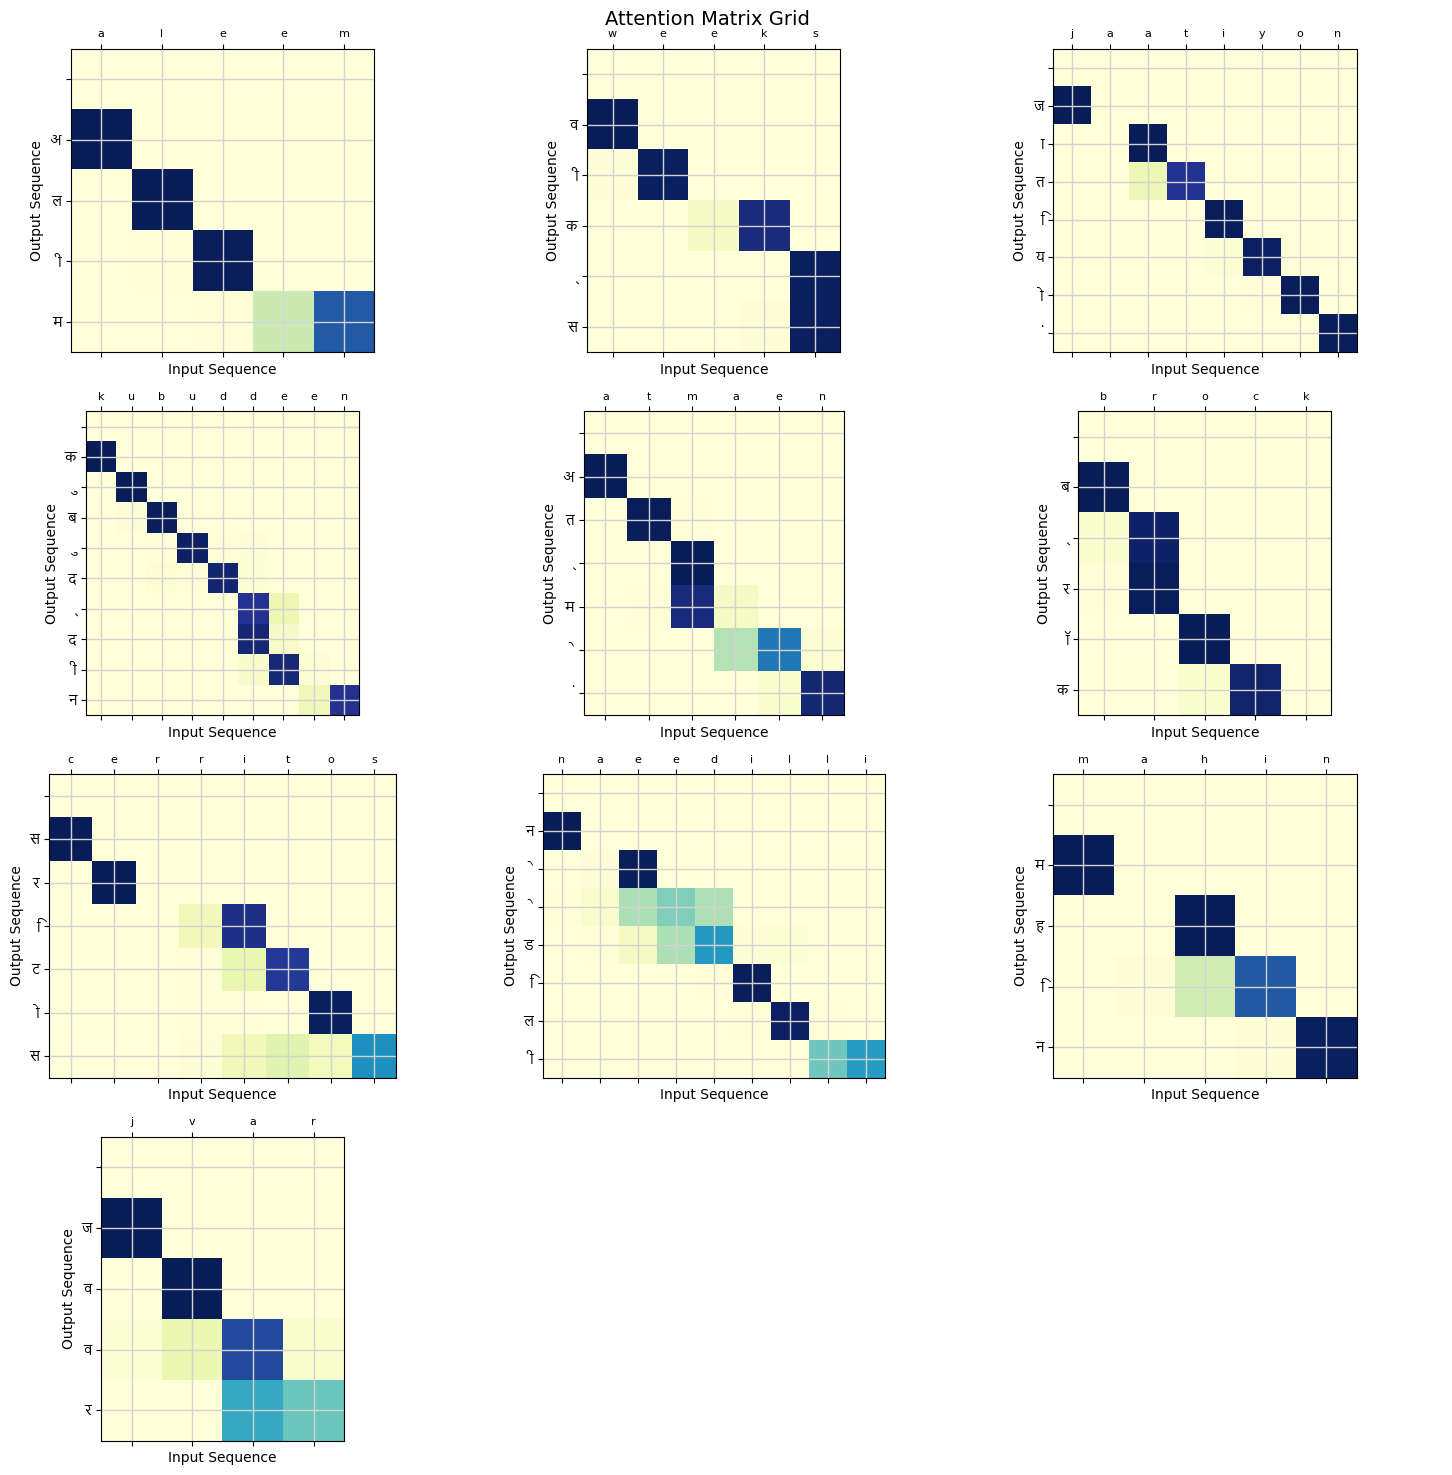

In [35]:
random_pairs = random.sample(list(zip(preprocessed_data['test_words'], preprocessed_data['test_translations'])), 10)
inputs, outputs, attentions = [], [], []
for i, (w, t) in enumerate(random_pairs):
    word, translation = w[:-1], t[:-1]
    output, attention = predict(trained_model, word, preprocessed_data, params)
    attention = attention[:, :, :(len(word))]
    inputs.append(word)
    outputs.append(' '+output)
    attentions.append(attention)
plot_attention_grid(inputs, outputs, attentions)